In [1]:
# import libraries
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import re
from functools import *

%matplotlib widget

In [2]:
# define the classes
class Point:
    id: int
    coord: np.ndarray
    dominant: int
    second_dominant: int
    values: list[float]
    tissue: bool

point_list: list[Point] = []
edge_set: set[tuple[int]] = set()
triangle_set: set[tuple[int]] = set()
tetrahedron_set: set[tuple[int]] = set()


In [3]:
# load from st data files
# points_data = pd.read_csv("assets/HT112C1/points.csv", header=None)
# tets_data = pd.read_csv("assets/HT112C1/tets.csv", header=None)

# load from toy data files
# points_data = pd.read_csv("assets/torus-points.csv")
# tets_data = pd.read_csv("assets/torus-tets.csv")

# load from new toy data files
points_data = pd.read_csv("assets/toy-data-1/points.csv", header=None)
tets_data = pd.read_csv("assets/toy-data-1/tets.csv", header=None)

# points_data = pd.read_csv("assets/small-torus/points.csv", header=None)
# tets_data = pd.read_csv("assets/small-torus/tets.csv", header=None)

if points_data.isna().any().any():
    raise ValueError("NaN values detected in the data file!")

In [4]:
coords = points_data.iloc[:, :3]
x_limits = coords.iloc[:, 0].agg(["min", "max"]).tolist()
y_limits = coords.iloc[:, 1].agg(["min", "max"]).tolist()
z_limits = coords.iloc[:, 2].agg(["min", "max"]).tolist()

x_range = abs(x_limits[1] - x_limits[0])
x_middle = (x_limits[0] + x_limits[1]) / 2
y_range = abs(y_limits[1] - y_limits[0])
y_middle = (y_limits[0] + y_limits[1]) / 2
z_range = abs(z_limits[1] - z_limits[0])
z_middle = (z_limits[0] + z_limits[1]) / 2

plot_radius = 0.5 * max([x_range, y_range, z_range])

# plot the point cloud
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(points_data.iloc[:, 0].to_numpy(), points_data.iloc[:, 1].to_numpy(), points_data.iloc[:, 2].to_numpy())
# ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
# ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
# ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
# plt.show()

In [5]:
num_materials = points_data.shape[1] - 3

for i, row in points_data.iterrows():
    point = Point()
    point.id = i
    point.coord = row.iloc[:3]
    values = row.iloc[3:]
    point.dominant = values.idxmax() - 3
    point.second_dominant = values.nlargest(2).iloc[1:].idxmax() - 3
    point.values = values.to_list()
    point.tissue = point.dominant != num_materials - 1
    point_list.append(point)


edge_combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
triangle_combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]


def same_material(point_indices):
    return all([point_list[point].dominant == point_list[point_indices[0]].dominant for point in point_indices])


def all_valid(point_indices):
    return all([point_list[point].tissue for point in point_indices])


# TODO: use hash table for faster lookup
for i, tet in tets_data.iterrows():
    edges = [sorted([tet.iloc[combination[0]], tet.iloc[combination[1]]]) for combination in edge_combinations]
    [edge_set.add(tuple(x)) for x in edges if all_valid(x)]
    triangles = [
        sorted([tet.iloc[combination[0]], tet.iloc[combination[1]], tet.iloc[combination[2]]]) for combination in triangle_combinations
    ]
    [triangle_set.add(tuple(x)) for x in triangles if all_valid(x)]
    if all_valid(tet):
        tetrahedron_set.add(tuple(sorted(tet)))

In [6]:
points_by_material = [[] for _ in range(num_materials)]
faces_by_material = [[] for _ in range(num_materials)]
point_index_in_material_group = {}
face_index_in_material_group = {}

for i, point in enumerate(point_list):
    points_by_material[point.dominant].append(point)
    point_index_in_material_group[i] = len(points_by_material[point.dominant]) - 1

for i, triangle in enumerate(triangle_set):
    if point_list[triangle[0]].dominant == point_list[triangle[1]].dominant and point_list[triangle[0]].dominant == point_list[triangle[2]].dominant:
        faces_by_material[point_list[triangle[0]].dominant].append(triangle)
        face_index_in_material_group[i] = len(faces_by_material[point_list[triangle[0]].dominant]) - 1

Material 0 has 48 points, 197 edges, 258 triangles, 108 tets, 611 simplices in total
Material 0 dimension 0 has 0 finite points and 1 infinite points


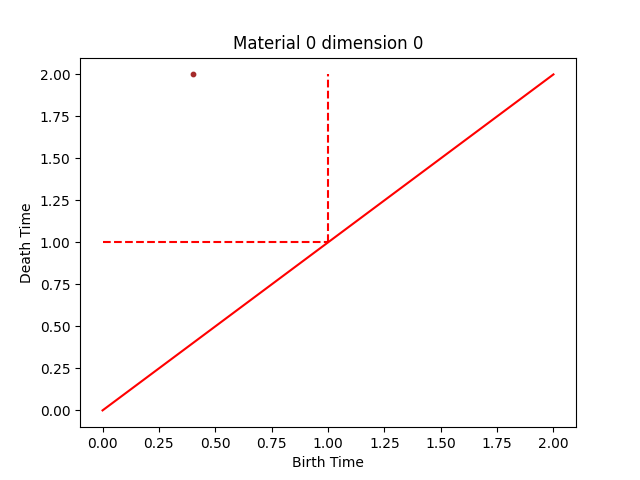

Material 0 dimension 1 has 0 finite points and 0 infinite points


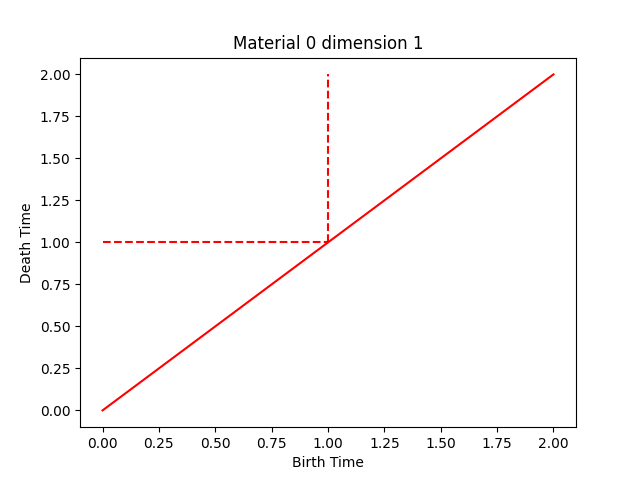

Material 0 dimension 2 has 0 finite points and 0 infinite points


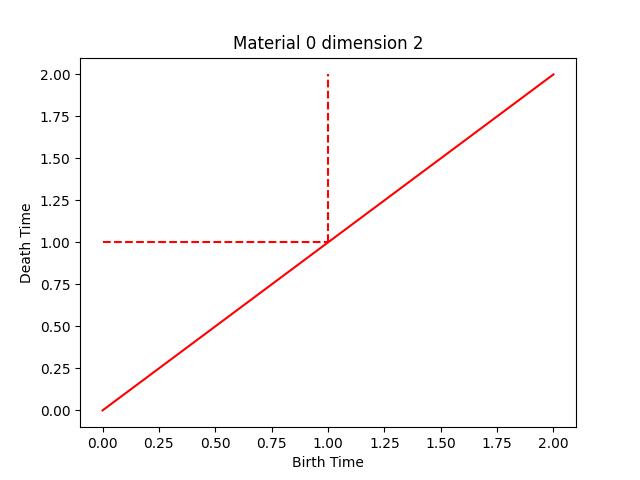

Material 0 has 4 but no faces, 3D mesh display skipped
Material 1 has 48 points, 197 edges, 258 triangles, 108 tets, 611 simplices in total
Material 1 dimension 0 has 1 finite points and 1 infinite points


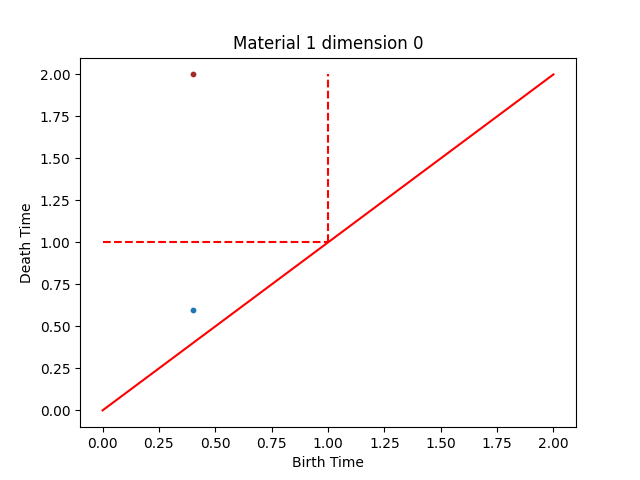

Material 1 dimension 1 has 1 finite points and 0 infinite points


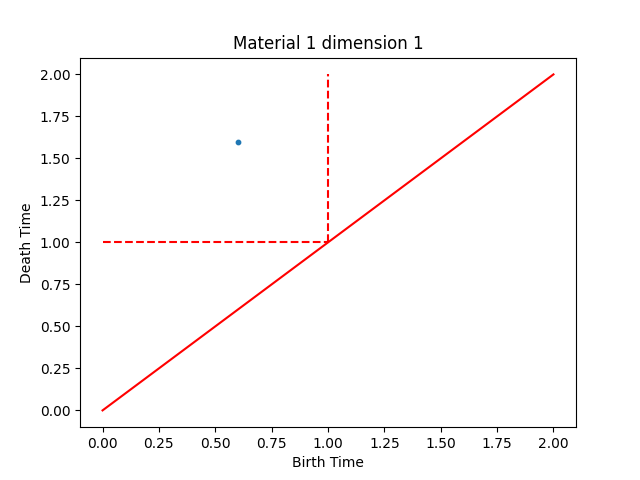

Material 1 dimension 2 has 0 finite points and 0 infinite points


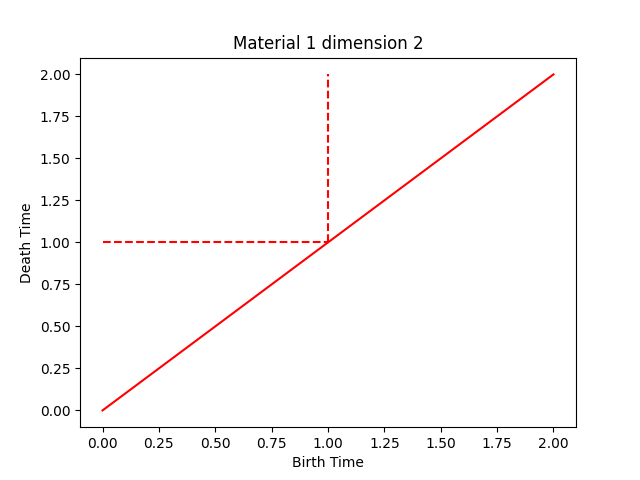

Material 1 has 44 points and 174 faces


Material 2 has 48 points, 197 edges, 258 triangles, 108 tets, 611 simplices in total
Material 2 dimension 0 has 1 finite points and 1 infinite points


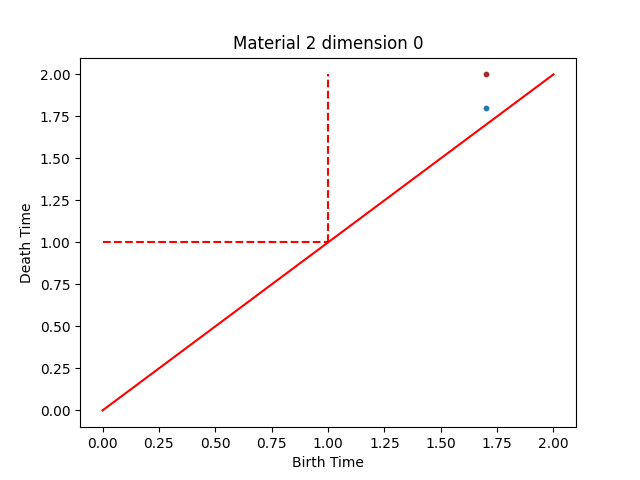

Material 2 dimension 1 has 0 finite points and 0 infinite points


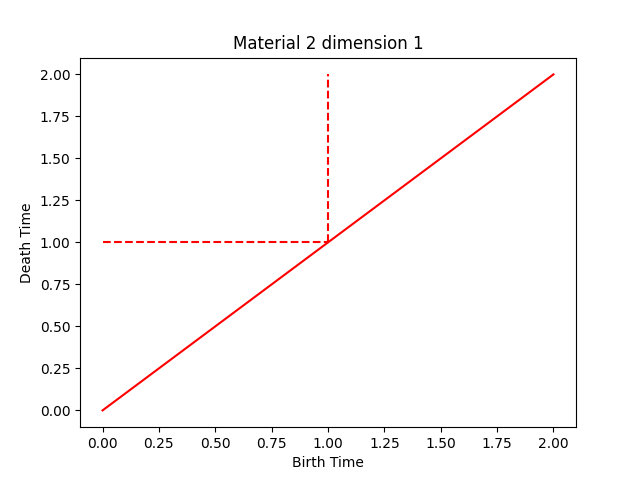

Material 2 dimension 2 has 0 finite points and 0 infinite points


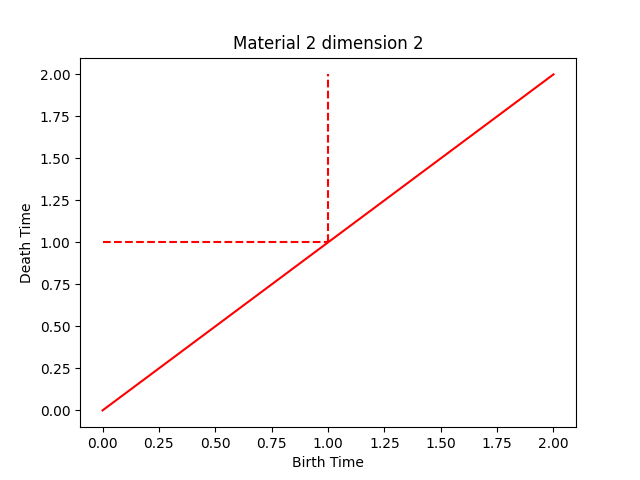

Material 2 has 392 but no faces, 3D mesh display skipped


In [7]:
generator_by_material_and_dimension = [[] for _ in range(num_materials)]
filtrations_by_material = [[] for _ in range(num_materials)]
ph_matrix_by_material = [[] for _ in range(num_materials)]
diagrams_by_material = [[] for _ in range(num_materials)]

# point_index_filtered = [None for _ in range(len(point_list))]
# count = 0
# for i, point in enumerate(point_list):
#     if point.tissue:
#         point_index_filtered[i] = count
#         count += 1

def get_value(point, material):
    values = point.values
    if material == point.dominant:
        return values[point.dominant] - values[point.second_dominant]
    else:
        return values[material] - values[point.dominant]


# iterate through the materials
for material in range(num_materials):
    if len(points_by_material[material]) == 0:
        print(f"Material {material} has no points")
        continue

    points = [([point.id], 1 - get_value(point, material)) for point in point_list if point.tissue]
    edges = [(list(edge), 1 - min([get_value(point_list[point], material) for point in edge])) for edge in edge_set]
    triangles = [(list(triangle), 1 - min([get_value(point_list[point], material) for point in triangle])) for triangle in triangle_set]
    tets = [(list(tet), 1 - min([get_value(point_list[point], material) for point in tet])) for tet in tetrahedron_set]

    simplices = []
    simplices.extend(points)
    simplices.extend(edges)
    simplices.extend(triangles)
    simplices.extend(tets)

    print(f"Material {material} has {len(points)} points, {len(edges)} edges, {len(triangles)} triangles, {len(tets)} tets, {len(simplices)} simplices in total")

    filtration = d.Filtration()
    for vertices, time in simplices:
        filtration.append(d.Simplex(vertices, time))
    filtration.sort()

    ph_matrix = d.homology_persistence(filtration, method="column")
    diagrams = d.init_diagrams(ph_matrix, filtration)

    for i, diagram in enumerate(diagrams):
        if i == 3:
            continue

        plt.figure()
        plt.title(f"Material {material} dimension {i}")
        filtered_diagram = [pt for pt in diagram if pt.birth < pt.death]

        # filter points that live forever
        finite_birth_times = [pt.birth for pt in filtered_diagram if pt.death != float("inf")]
        finite_death_times = [pt.death for pt in filtered_diagram if pt.death != float("inf")]
        infinite_birth_times = [pt.birth for pt in filtered_diagram if pt.death == float("inf")]
        infinite_death_times = [2.0 for pt in filtered_diagram if pt.death == float("inf")]

        print(
            f"Material {material} dimension {i} has {len(finite_birth_times)} finite points and {len(infinite_birth_times)} infinite points"
        )

        # plot using plt.scatter instead
        plt.scatter(finite_birth_times, finite_death_times, s=10)
        plt.scatter(infinite_birth_times, infinite_death_times, s=10, color="brown")
        plt.plot([0, 2], [0, 2], "r")
        plt.plot([1, 1], [1, 2], "r--")
        plt.plot([0, 1], [1, 1], "r--")
        plt.xlabel("Birth Time")
        plt.ylabel("Death Time")
        plt.show()

    # dictionary to reverse lookup the killer of a homology
    pairs = {}
    for j in range(len(ph_matrix)):
        if ph_matrix.pair(j) != ph_matrix.unpaired:
            pairs[ph_matrix.pair(j)] = j

    # sort the points on the diagram by lifespan
    # diagrams_sorted = [[] for _ in range(4)]
    # for dimension, diagram in enumerate(diagrams):
    #     diagram_sorted = sorted(list(filter(lambda x: x[1] != float("inf"), map(lambda x: (x, x.death - x.birth), diagram))), reverse=True, key=lambda x: x[1])
    #     diagrams_sorted[dimension] = diagram_sorted


    # finding the generators for 1 and 2 cycle
    diagrams_sorted = [[] for _ in range(4)]
    generators_by_dimension = [None for _ in range(4)]
    for dimension, diagram in enumerate(diagrams):
        generators = []
        diagram_sorted = sorted(list(filter(lambda x: x[1] != float("inf"), map(lambda x: (x, x.death - x.birth), diagram))), reverse=True, key=lambda x: x[1])
        diagrams_sorted[dimension] = diagram_sorted

        for (point, lifespan) in diagram_sorted:
            if point.birth > 1.0 or point.death < 1.0 or point.death == float("inf"):
                continue

            generator = [[int(s) for s in re.findall(r'<(.*?)>', str(filtration[int(index)]))[0].split(',')] for index in re.findall(r'\*(\d+)', str(ph_matrix[pairs.get(point.data)]))] if pairs.get(point.data) != None else []
            generators.append((generator, point.death - point.birth))

        # print(generators)
        # generators.sort(reverse=True, key=lambda x: x[1])
        generators_by_dimension[dimension] = [g[0] for g in generators]
    
    generator_by_material_and_dimension[material] = generators_by_dimension
    
    # vertices = [list(point_list[point[0][0]].coord) for point in points]
    # intensities = [point[1] for point in points]
    # faces = [[point_index_filtered[v] for v in triangle[0]] for triangle in triangles]

    vertices = [list(point.coord) for point in points_by_material[material]]
    intensities = [point.values[material] for point in points_by_material[material]]
    faces = [[point_index_in_material_group[v] for v in face] for face in faces_by_material[material]]

    cycle_lengths = [len(loop) for loop in generators_by_dimension[1]]
    total_num_edges = reduce(lambda x, y: x + y, cycle_lengths) if len(cycle_lengths) else 0

    cycle_edge_index_range = []
    accumulation = 0
    for length in cycle_lengths:
        if length: 
            index_range = (accumulation, accumulation + length - 1)
        else:
            index_range = (-1, -1)
        cycle_edge_index_range.append(index_range)
        accumulation += length

    if len(faces) == 0: 
        print(f"Material {material} has {len(vertices)} but no faces, 3D mesh display skipped")
        continue
    else:
        print(f"Material {material} has {len(vertices)} points and {len(faces)} faces")

    x, y, z = zip(*vertices)
    i, j, k = zip(*faces)

    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=intensities, colorscale=[[0, 'navy'], [0.25, 'cyan'], [0.5, 'lime'], [0.75, 'yellow'], [1, 'red']], opacity=0.01)])

    sliders = [{
        'steps': [
            {
                'label': f'{opacity:.1f}',
                'method': 'restyle',
                'args': [{'opacity': opacity}, [0]]
            } for opacity in [i/10 for i in range(1, 11)]
        ],
        'currentvalue': {'prefix': 'Opacity: ', 'font': {'size': 20}},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'xanchor': 'left',
        'y': -0.1,  
        'yanchor': 'top'
    },
    {
        'active': 0,
        'currentvalue': {'prefix': 'Loop: ', 'font': {'size': 20}},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'xanchor': 'left',
        'y': -0.5, 
        'yanchor': 'top',
        'steps': [
            {
                'label': 'All',
                'method': 'update',
                'args': [{'visible': [True] * (total_num_edges + 1)}]
            }
        ] + [
            {
                'label': f'{i+1}',
                'method': 'update',
                'args': [{'visible': [True] + [cycle_edge_index_range[i][0] <= e <= cycle_edge_index_range[i][1] for e in range(total_num_edges)]}]
            } for i in range(min(len(generators_by_dimension[1]), 10))
        ] + [
            {
                'label': 'None',
                'method': 'update',
                'args': [{'visible': [True] + [False] * total_num_edges}]
            }
        ]
    }
    ]

    updatemenus=[{
        'type': 'buttons',
        'buttons': [
            {
                'label': 'Opacity 0.01',
                'method': 'restyle',
                'args': [{'opacity': 0.01}, [0]]
            },
            {
                'label': 'Opacity 0.1',
                'method': 'restyle',
                'args': [{'opacity': 0.1}, [0]]
            },
            {
                'label': 'Opacity 1.0',
                'method': 'restyle',
                'args': [{'opacity': 1.0}, [0]]
            }
        ]
    }]

    fig.update_layout(scene=dict(
        xaxis=dict(range=[x_middle - plot_radius, x_middle + plot_radius]),
        yaxis=dict(range=[y_middle - plot_radius, y_middle + plot_radius]),
        zaxis=dict(range=[z_middle - plot_radius, z_middle + plot_radius]),
        aspectmode='manual'),
        title_text=f"Material {material}",
        width=800,
        height=600,
        updatemenus=updatemenus,
        sliders=sliders
    )

    def plot_edge(fig, edge):
        edge = [list(point_list[endpoint].coord) for endpoint in edge]
        fig.add_trace(go.Scatter3d(
            x=[edge[0][0], edge[1][0], None], 
            y=[edge[0][1], edge[1][1], None], 
            z=[edge[0][2], edge[1][2], None],
            mode='lines',
            showlegend=False,
            line=dict(color='black', width=5),
            name="edges"
        ))

    # display the edges of 1-cycles
    # handles = [[[list(point_list[endpoint].coord) for endpoint in edge] for edge in loop ] for loop in generators_by_dimension[1]]
    num_edges = 0
    [[plot_edge(fig, edge) for edge in loop ] for loop in generators_by_dimension[1]]
    fig.show()

    filtrations_by_material[material] = filtration
    ph_matrix_by_material[material] = ph_matrix
    diagrams_by_material[material] = diagrams